# Image Prompt Playground

The [Prerequisites](00-prerequisites.ipynb), [Video segments: frames, shots and scenes](01A-visual-segments-frames-shots-scenes.ipynb) and [Ad Breaks and Contextual Ad Targeting](02-ad-breaks-and-contextual-ad-targeting.ipynb) notebooks are prerequisites for this prompting exercise.

In the Ad break detection and contextual Ad targeting notebook, we assembled video frames associated with topics and created composite image grids.  You can go back to that notebook and look at the section titled "Generate chapter level contextual information" for a visual description of the flow.  

Here, we are going to walk you through the prompt we generate using shots and show you how Claude responds based on the prompting.

First let's load all the necessary code and imports.

In [1]:
from pathlib import Path
import os
import json
import json
import boto3
from botocore.exceptions import ClientError
import json_repair
import copy
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript
#from lib.chapters import Chapters
from lib import frame_utils
from lib import util
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import copy
import time

# Supporting code

Below you will find a number of methods we pulled out of our [bedrock_helper](./lib/bedrock_helper.py) python module.  We've done this to expose the prompts so that you can see how your prompts impact the response.

In [2]:
class Chapters:
    def __init__(self, topics, scenes, frames):
        self.video_asset_dir = frames.video_asset_dir()
        self.chapters = self.align_scenes_in_chapters(topics, scenes, frames)
        
    def align_scenes_in_chapters(self, topics, scenes, frames):
        """
        Aligns video scenes with conversation topics to create chronological chapters.
    
        Args:
            topics: List of conversation topics with start_ms, end_ms, and reason
            scenes: List of scene metadata with start_ms and end_ms
            frames: List of video frame metadata
    
        Returns:
            List of chapters, each containing aligned scenes and associated text
    
        Note:
            - Handles scenes without conversations
            - Merges overlapping topics
            - Preserves chronological order
            - Creates Chapter objects for each segment
    """
        scenes = copy.deepcopy(scenes)
    
        chapters = []
        for topic in topics:
            
            topic_start_ms = topic['start_ms']
            topic_end_ms = topic['end_ms']
            text = topic['reason']

            # find all the frames that align with the conversation topic
            stack = []
            while len(scenes) > 0:
                scene = scenes[0]
                frame_start = scene['start_ms']
                frame_end = scene['end_ms']

                
                if frame_start > topic_end_ms:
                    # topic overlaps scenes that belong to previous topic - merge the text
                    if not stack:
                        num_chapters = len(chapters)
                        if num_chapters > 0:
                            chapters[num_chapters-1]['text'] = chapters[num_chapters-1]['text'] + ' ' + text
                        
                    break
    
                # scenes before any conversation starts
                if frame_end < topic_start_ms:
                    chapter = Chapter(len(chapters), [scene], frames).__dict__
                    chapters.append(chapter)
                    scenes.pop(0)
                    continue
    
                stack.append(scene)
                scenes.pop(0)
    
            if stack:
                chapter = Chapter(len(chapters), stack, frames, text).__dict__
                chapters.append(chapter)
    
        ## There could be more scenes without converations, append them
        for scene in scenes:
            chapter = Chapter(len(chapters), [scene], frames).__dict__
            chapters.append(chapter)
    
        return chapters

class Chapter:
    def __init__(self, chapter_id, scenes, frames, text = ''):
        self.scene_ids = [scene['id'] for scene in scenes]
        self.start_frame_id = scenes[0]['start_frame_id']
        self.end_frame_id = scenes[-1]['end_frame_id']
        self.start_ms = scenes[0]['start_ms']
        self.end_ms = scenes[-1]['end_ms']
        self.id = chapter_id
        self.text = text
        #folder = os.path.join(frames.video_asset_dir(), 'chapters')
        #os.makedirs(folder, exist_ok=True) 
        self.composite_images = frames.create_composite_images(frames.frames[self.start_frame_id:self.end_frame_id+1], 'chapters', prefix="chapter_")
        
        return 


In [3]:
%store -r

# Encoding the images for Claude

The method make_image_message() will take a number of images and base64 encode them so we can send them to Claude for understanding.  

In [4]:
#
# encode the images along with a prompt so that we can get some context about our frames or scenes from the LLM
#
def make_image_message(composite_images):
    # adding the composite image sequences
    image_contents = [{
        'type': 'text',
        'text': 'Here are {0} images containing a frame sequence that describes a scene.'.format(len(composite_images))
    }]

    open_images = []
    for image in composite_images:
        with open(image['file'], "rb") as image_file:
            image_data = image_file.read()
            open_images.append(image_file)
        image_pil = Image.open(BytesIO(image_data))
        bas64_image = frame_utils.image_to_base64(image_pil)
        image_contents.append({
            'type': 'image',
            'source': {
                'type': 'base64',
                'media_type': 'image/jpeg',
                'data': bas64_image
            }
        })

    # close the images
    for image in open_images:
        image.close()

    return {
        'role': 'user',
        'content': image_contents
    }


#
# get rid of the encoded image data which results in a very long output message and just clutters things up
#
def remove_data_field(obj):
    if isinstance(obj, dict):
        return {k: remove_data_field(v) if k != 'data' else '<snip>' for k, v in obj.items()}
    elif isinstance(obj, list):
        return [remove_data_field(item) for item in obj]
    return obj


def make_output_example():
    example = {
        'description': {
            'text': 'The scene describes...',
            'score': 98
        },
        'sentiment': {
            'text': 'Positive',
            'score': 90
        },
        'genre': {
            'text': 'True Crime',
            'score': 80
        },
        'relevant_tags': [
            {
                'text': 'BMW',
                'score': 95
            }
        ]            
    }
    
    return {
        'role': 'user',
        'content': 'Return JSON format. An example of the output:\n{0}\n'.format(json.dumps(example))
    }


#
# use this method to show what's being passed to the LLM.  It will strip out the encoded image
# information that clutters up the output. 
#
def show_llm_messages(model_params):
    print(f'\nMessages:\n')
    for message in model_params:
        try:
            cleaned_message = remove_data_field(message)
            json_string = json.dumps(cleaned_message, indent=2)
            print(json_string)
        except Exception as e:
            print(f"Error encoding message: {e}")
    print('\n')

# Get Contextual Information

Below you find the get_contextual_information() method that is in our [bedrock_helper](./lib/bedrock_helper.py) Python module.  We've made some modifications so that you can pass a variety of system and user prompts and observe the effect on outputs from Claude. 

In [5]:
from lib import bedrock_helper as brh

#
# This is the meat of the code that builds up the conversation to pass to the LLM.
#
def get_contextual_information(images, system_prompt, user_prompt):
    messages = []
    # adding sequences of composite images to the prompt.  Limit is 20.
    message_images = make_image_message(images[:19])
    messages.append(message_images)

    # other information
    messages.append({
        'role': 'assistant',
        'content': 'OK. Do you have other information to provdie?'
    })

    other_information = []

    ## Sentiment
    sentiment_list = brh.make_sentiments()
    other_information.append(sentiment_list)

    messages.append({
        'role': 'user',
        'content': other_information
    })

    # output format
    messages.append({
        'role': 'assistant',
        'content': 'OK. What output format?'
    })
    output_format = make_output_example()
    messages.append(output_format)

    # prefill '{'
    messages.append({
        'role': 'assistant',
        'content': '{'
    })    
    formatted_system_prompt = system_prompt.format(user_prompt)
    model_params = {
        'anthropic_version': brh.MODEL_VER,
        'max_tokens': 4096,
        'temperature': 0.1,
        'top_p': 0.7,
        'top_k': 20,
        'stop_sequences': ['\n\nHuman:'],
        'system': formatted_system_prompt,
        'messages': messages
    }

    try:
        response = brh.inference(model_params)
    except Exception as e:
        print(colored(f"ERR: inference: {str(e)}\n RETRY...", 'red'))
        response = inference(model_params)

    return formatted_system_prompt, messages, response

# Our main method

Below is the code we will use to display the image we are passing to Claude, call get_contextual_information() to have the actual conversation with the model and then display the cost of the conversation.  This is the main method for testing different prompts.

In [6]:
def prompt_llm(image_list, system_prompt, user_prompt):

    total_usage = {
        'input_tokens': 0,
        'output_tokens': 0,
    }
    
    for idx, composite_image in enumerate(image_list):
        print (f'\nImage {idx+1 } of { len(image_list) }: { composite_image["file"] }\n')
        display(DisplayImage(filename=composite_image['file']))
    
    conversation_text = ''
    
    print("\nSending conversation to LLM ...")
    system_prompt, messages, contextual_response = get_contextual_information(image_list, system_prompt, user_prompt)
    print("Got a response\n")
    
    usage = contextual_response['usage']
    contextual = contextual_response['content'][0]['json']
    
    total_usage['input_tokens'] += usage['input_tokens']
    total_usage['output_tokens'] += usage['output_tokens']
    
    for key in ['description', 'sentiment']:
        print(f"{key.capitalize()}: {colored(contextual[key]['text'], 'green')} ({contextual[key]['score']}%)")
    
    for key in ['relevant_tags']:
        try:
            items = ', '.join([item['text'] for item in contextual[key]])
            if len(items) == 0:
                items = 'None'
            print(f"{key.capitalize()}: {colored(items, 'green')}")
        except KeyError:
            pass
    print(f"================================================")
    
    contextual_cost = brh.display_contextual_cost(total_usage)

    return system_prompt, messages, contextual_response

# Let's do some setup before we talk to Claude

Below we define our system prompt as well as an image list for which we want contextual information.   The system prompt is the foundational model's role in gathering the contextual information and instructions on how to interpret the input. We are going to leave this alone.  The user prompt is what you will change for different tasks.  For example you may want to get a summarization of a shot, or classify the scene and get the genre.  This first prompt is going to be somewhat detaild and include tags, brands and logos.

We are using the video['shots'] structure to access the shots we generated in the previous notebook.  If you'd like to look at the various shots, you can look in the folder we print out below.  We also display the JSON video shots dictionary entry where you can see the composite_images that we pass to Claude.  Each shot is a single image made up of multiple frames.

In [7]:
user_prompt = 'You are asked to provide the following information: a detail description to describe the scene, identify sentiment, brands and logos that may appear in the scene, and five most relevant tags from the scene.'
system_prompt = 'You are a media operation engineer. Your job is to review a portion of a video content presented in a sequence of consecutive images. Each image may also contain a sequence of frames presented in a 4x7 grid reading from left to right and then from top to bottom. {0} It is important to return the results in JSON format and also include a confidence score from 0 to 100. Skip any explanation.'


print("\nThe images we will be using are stored in", "./"+video["output_dir"]+"/shots/\n")

idx = 4
print("Shot", "#"+str(idx+1))
shot = video['shots'].shots[idx]


display("video['shots'].shots[idx] JSON ->", JSON(shot))
image_list = [ { 'file' :shot['composite_images'][0]['file'] } ]


The images we will be using are stored in ./Netflix_Open_Content_Meridian/shots/

Shot #5


"video['shots'].shots[idx] JSON ->"

<IPython.core.display.JSON object>


Image 1 of 1: ./Netflix_Open_Content_Meridian/shots/shot_frames0000015-frames0000016.jpg



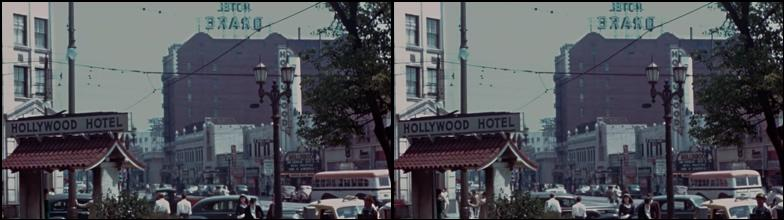


Sending conversation to LLM ...
Got a response

Description: The scene depicts a busy street in what appears to be an urban area, likely from the mid-20th century based on the architecture and vehicles shown. A large neon sign for a hotel called 'Hollywood Hotel' is prominently displayed, along with another neon sign for a business called 'Star Cafe'. The street is lined with parked cars and pedestrians walking along the sidewalks. (95%)
Sentiment: Neutral (90%)
Relevant_tags: urban street scene, mid-20th century, neon signs, vintage cars, pedestrians


Estimated cost: $0.0063 in us-east-1 region with 524 input tokens and 318 output tokens.


In [8]:
#
# Call Claude via the Bedrock API
#
system_prompt, messages, contextual_response = prompt_llm(image_list, system_prompt, user_prompt)

# Conversation with Claude using Bedrock

Let's take a look at the conversation we've sent to Claude via Bedrock.  We are using the [Anthropic Claude Messages API](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html).

We've stripped out the base64 encoded image(s) for display purposes and replaced them with "\<snip\>".   The "user" messages are from the user (you) and the "assistant" is Claude.  You will get a response to your prompt along with the calculated cost from the Bedrock call.  We also provide the JSON messages that we sent via the API so you can see how the conversation is constructed.

In [9]:
print("\n")
display("user_prompt:", user_prompt)
print("\n")
display("system_prompt:", system_prompt)
print("\n")
display("messages", JSON(remove_data_field(messages), expanded=1))
print("\n")
display("contextual_response:", JSON(contextual_response, expanded=1))

'user_prompt:'

'You are asked to provide the following information: a detail description to describe the scene, identify sentiment, brands and logos that may appear in the scene, and five most relevant tags from the scene.'

'system_prompt:'

'You are a media operation engineer. Your job is to review a portion of a video content presented in a sequence of consecutive images. Each image may also contain a sequence of frames presented in a 4x7 grid reading from left to right and then from top to bottom. You are asked to provide the following information: a detail description to describe the scene, identify sentiment, brands and logos that may appear in the scene, and five most relevant tags from the scene. It is important to return the results in JSON format and also include a confidence score from 0 to 100. Skip any explanation.'

'messages'

<IPython.core.display.JSON object>

'contextual_response:'

<IPython.core.display.JSON object>

# New prompt - Classification

Let's try changing the prompt and see what we get.  This time we will ask just about the genre and ask Claude to give that in the description.  We've unraveled the contextual_response JSON to show you the genre tag that now shows up.


Image 1 of 1: ./Netflix_Open_Content_Meridian/shots/shot_frames0000022-frames0000024.jpg



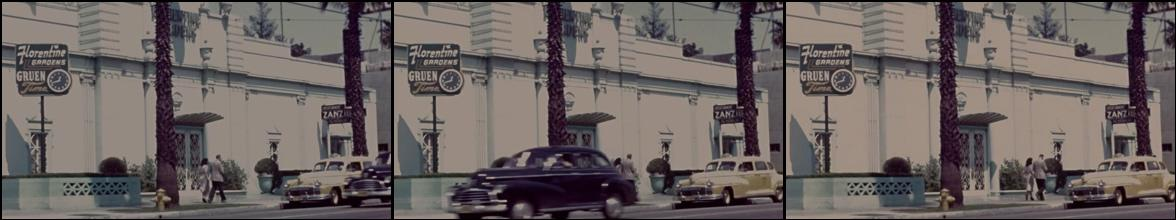


Sending conversation to LLM ...
Got a response

Description: The scene appears to depict a street scene from the mid-20th century, with vintage cars parked outside a building with a neon sign. (95%)
Sentiment: Neutral (100%)
Relevant_tags: None


Estimated cost: $0.0035 in us-east-1 region with 605 input tokens and 115 output tokens.




'user_prompt:'

'Please give the genre of the movie.'

'system_prompt:'

'You are a media operation engineer. Your job is to review a portion of a video content presented in a sequence of consecutive images. Each image may also contain a sequence of frames presented in a 4x7 grid reading from left to right and then from top to bottom. Please give the genre of the movie. It is important to return the results in JSON format and also include a confidence score from 0 to 100. Skip any explanation.'

'messages'

<IPython.core.display.JSON object>

'contextual_response:'

<IPython.core.display.JSON object>

In [15]:
user_prompt = 'Please give the genre of the movie.'
system_prompt = 'You are a media operation engineer. Your job is to review a portion of a video content presented in a sequence of consecutive images. Each image may also contain a sequence of frames presented in a 4x7 grid reading from left to right and then from top to bottom. {0} It is important to return the results in JSON format and also include a confidence score from 0 to 100. Skip any explanation.'


# media-analysis-with-generative-ai-on-aws/Netflix_Open_Content_Meridian/chapters/chapter_frames0000403-frames0000431.jpg

#
# notice that in get_contextual_information() above, we are going to compose the user and system prompt.  You can see the {0}
# place holder in system_prompt above.
#
#  'system': system_prompt.format(user_prompt),
#
system_prompt, messages, contextual_response = prompt_llm(image_list, system_prompt, user_prompt)

print("\n")
display("user_prompt:", user_prompt)
print("\n")
display("system_prompt:", system_prompt)
print("\n")
display("messages", JSON(remove_data_field(messages), expanded=1))
print("\n")
display("contextual_response:", JSON(contextual_response, expanded=2))

# Summarize a Shot

Let's ask Claude to summarize what's in a Shot.  Play around with the prompt to see how you get Claude to give you the information you want from the images.

shot 8


"video['shots'] JSON ->"

<IPython.core.display.JSON object>


Image 1 of 1: ./Netflix_Open_Content_Meridian/shots/shot_frames0000022-frames0000024.jpg



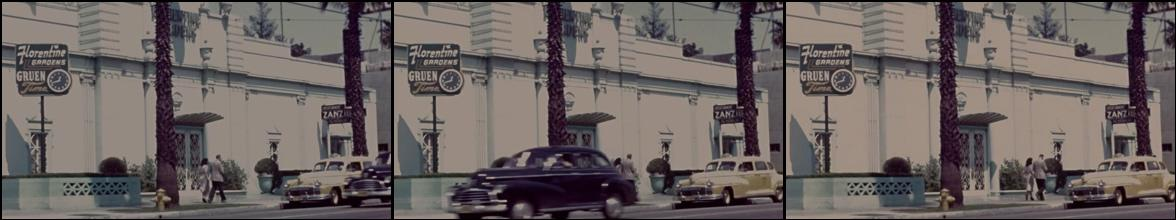


Sending conversation to LLM ...
Got a response

Description: The scene shows a street view with vintage cars parked in front of a building with a neon sign. There are pedestrians walking on the sidewalk. (95%)
Sentiment: Neutral (90%)
Relevant_tags: None


Estimated cost: $0.0032 in us-east-1 region with 602 input tokens and 92 output tokens.


In [11]:
user_prompt = 'Summarize the scene'
system_prompt = 'You are a media operation engineer. Your job is to review a portion of a video content presented in a sequence of consecutive images. Each image may also contain a sequence of frames presented in a 4x7 grid reading from left to right and then from top to bottom. {0} It is important to return the results in JSON format and also include a confidence score from 0 to 100. Skip any explanation.'


idx = 7
print("shot", idx+1)
shot = video['shots'].shots[idx]
display("video['shots'] JSON ->", JSON(shot))
image_list = [ { 'file' :shot['composite_images'][0]['file'] } ]


#
# notice that in get_contextual_information() above, we are going to compose the user and system prompt.  You can see the {0}
# place holder in system_prompt above.
#
#  'system': system_prompt.format(user_prompt),
#
system_prompt, messages, contextual_response = prompt_llm(image_list, system_prompt, user_prompt)

# Keep going

Now go back up to where we first setup the user and system prompts.  Change the user_prompt and "idx =" line that selects a shot and see how the model output changes.